## Behavioral Cloning Project

### Import data provided and create training set

In [19]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

lines = []

with open('my_drive_2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in tqdm(reader):
        lines.append(line)

lines = lines[1:]
images = []
measurements = []

# steering measurement correction as suggested in video lectures to use left/right camera images in training
steering_measurement_correction = 0.23 # last value 0.22, vehicle driving on left lane

# read csv file and create arrays for training data
for line in tqdm(lines):
    
    source_path_center = line[0]
    filename_center_image = source_path_center.split('/')[-1]
    image_path_center = 'my_drive_2/IMG/' + filename_center_image
    image_center = cv2.imread(image_path_center)
    
    source_path_left = line[1]
    filename_left_image = source_path_left.split('/')[-1]
    image_path_left = 'my_drive_2/IMG/' + filename_left_image
    image_left = cv2.imread(image_path_left)
    
    source_path_right = line[2]
    filename_right_image = source_path_right.split('/')[-1]
    image_path_right = 'my_drive_2/IMG/' + filename_right_image
    image_right = cv2.imread(image_path_right)
    
    steering_center = float(line[3])
    steering_left = steering_center + steering_measurement_correction
    steering_right = steering_center - steering_measurement_correction
    
    images.append(image_center)
    measurements.append(steering_center)
    images.append(image_left)
    measurements.append(steering_left)
    images.append(image_right)
    measurements.append(steering_right)
    


image_paths = np.array(images)
measurements = np.array(measurements)
print('Captured measurements from raw training data:', image_paths.shape, measurements.shape)

# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 20
avg_samples_per_bin = len(measurements)/num_bins
hist, bins = np.histogram(measurements, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(measurements), np.max(measurements)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')


# determine keep probability for each bin: if below avg_samples_per_bin, keep all; 
# to number of samples above the average, so as to bring the number of samples for that bin down to the average
keep_probs = []
target = avg_samples_per_bin * .4
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(measurements)):
    for j in range(num_bins):
        if measurements[i] > bins[j] and measurements[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
image_paths = np.delete(image_paths, remove_list, axis=0)
measurements = np.delete(measurements, remove_list)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(measurements, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(measurements), np.max(measurements)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')


print('After removing most over-represented measurements:', image_paths.shape, measurements.shape)


X_train = np.array(image_paths)
y_train = np.array(measurements)
print(image_paths.shape)
n_steering_measurements = len(y_train)
n_images = len(X_train)

print('Number of images for X_train are:', n_images)
print('Number of steering measurements for y_train are:', \
      n_steering_measurements)



30163it [00:00, 304588.08it/s]
  1%|          | 187/30162 [00:00<02:30, 199.08it/s]


KeyboardInterrupt: 

### Visaulization and exploration of data

Random integer is:  8424
Shape of the image index random integer from X_train shape:  (160, 320, 3)
Corrsponding steering wheel measurement y_train value:  0.0


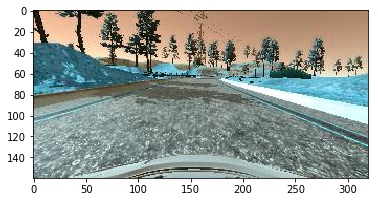

In [11]:
random_integer = np.random.randint(0,n_images)
print('Random integer is: ', random_integer)
print('Shape of the image index random integer from X_train shape: ',\
          X_train[random_integer].shape)
print('Corrsponding steering wheel measurement y_train value: ',\
          y_train[random_integer])

plt.imshow(X_train[random_integer])



### Preprocess, normalize and mean center data

100%|██████████| 18302/18302 [00:00<00:00, 100886.39it/s]


Corresponding steering angle measurement is:  0.0


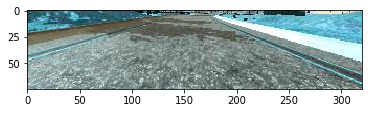

In [12]:
ROI_start_line = 60
ROI_end_line = 135

# Re-usable preprocess function that crops un-necessary part of images
def preprocess_image(image):
    """Returns croppped image
    """
    #print(image.shape)
    return image[ROI_start_line:ROI_end_line,:] 

X_train_preprocessed = np.copy(X_train[:,ROI_start_line:ROI_end_line,:,:])
for u in tqdm(range(0,len(X_train))):
    X_train_preprocessed[u] = preprocess_image(X_train[u])

random_preprocessed_image = X_train_preprocessed[random_integer]
steering_angle_measurement = y_train[random_integer]
plt.imshow(random_preprocessed_image)

print('Corresponding steering angle measurement is: ', steering_angle_measurement )


### Keras regression model as shown in Udacity video

In [13]:
''' Commented out since it's not part of neural network, however it is base structure of NN 
that can be built using Keras, as explained in video lectures

# Regression model to predict steering wheel

from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda

model = Sequential()
model.add(Lambda(lambda x:x/255.0 - 0.5, input_shape=(80,320,3)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train_preprocessed, y_train, validation_split=0.2, shuffle=True, \
          nb_epoch=7)
model.save('simpleRegressionModel.h5')          

print('Model saved..!')
'''

" Commented out since it's not part of neural network, however it is base structure of NN \nthat can be built using Keras, as explained in video lectures\n\n# Regression model to predict steering wheel\n\nfrom keras.models import Sequential\nfrom keras.layers import Flatten,Dense,Lambda\n\nmodel = Sequential()\nmodel.add(Lambda(lambda x:x/255.0 - 0.5, input_shape=(80,320,3)))\nmodel.add(Flatten())\nmodel.add(Dense(1))\n\nmodel.compile(loss='mse', optimizer='adam')\nmodel.fit(X_train_preprocessed, y_train, validation_split=0.2, shuffle=True,           nb_epoch=7)\nmodel.save('simpleRegressionModel.h5')          \n\nprint('Model saved..!')\n"

### Add Data Augmentation

In [14]:



augmented_images = []
augmented_measurements = []

# flip the image and also flip corresponding steering measurement
for k in tqdm(range(0,len(y_train))):
    image = X_train[k]
    measurement = y_train[k]
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)


X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_measurements)


n_images_augmented = len(X_train_augmented[:,0,0,0])
n_steering_measurements_augmented = len(y_train_augmented)
print('Number of images for X_train_augmented are:', n_images_augmented)
print('Number of steering measurements for y_train_augmented are:', \
      n_steering_measurements_augmented)




100%|██████████| 18302/18302 [00:07<00:00, 2610.81it/s]


Number of images for X_train_augmented are: 36604
Number of steering measurements for y_train_augmented are: 36604


### Preprocess, normalize and mean center augmented data

100%|██████████| 36604/36604 [00:00<00:00, 685262.67it/s]


Corresponding steering angle measurement is:  0.0


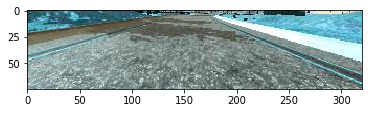

In [35]:
X_train_augmented_preprocessed = X_train_augmented[:,ROI_start_line:ROI_end_line,:,:]#np.copy(X_train_augmented[:,55:140,:,:])
for z in tqdm(range(0,len(X_train_augmented))):
    X_train_augmented_preprocessed[z] = preprocess_image(X_train_augmented[z])

random_integer_2 = np.random.randint(0,len(X_train_augmented_preprocessed))
random_augmented_preprocessed_image = X_train_augmented_preprocessed[random_integer_2]
steering_angle_measurement = y_train_augmented[random_integer_2]
plt.imshow(random_preprocessed_image)

print('Corresponding steering angle measurement is: ', steering_angle_measurement )



### Keras simple regression model as shown in video after data augmentation

In [36]:
'''
# Regression model to predict steering wheel

from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda

model2 = Sequential()
model2.add(Lambda(lambda x:x/255.0 - 0.5, input_shape=(80,320,3)))
model2.add(Flatten())
model2.add(Dense(1))

model2.compile(loss='mse', optimizer='adam')
model2.fit(X_train_augmented_preprocessed, y_train_augmented, validation_split=0.2, shuffle=True, \
          nb_epoch=5)
model2.save('simpleRegressionModelAfterDataAugmentation.h5')          

print('Model saved..!')
'''

"\n# Regression model to predict steering wheel\n\nfrom keras.models import Sequential\nfrom keras.layers import Flatten,Dense,Lambda\n\nmodel2 = Sequential()\nmodel2.add(Lambda(lambda x:x/255.0 - 0.5, input_shape=(80,320,3)))\nmodel2.add(Flatten())\nmodel2.add(Dense(1))\n\nmodel2.compile(loss='mse', optimizer='adam')\nmodel2.fit(X_train_augmented_preprocessed, y_train_augmented, validation_split=0.2, shuffle=True,           nb_epoch=5)\nmodel2.save('simpleRegressionModelAfterDataAugmentation.h5')          \n\nprint('Model saved..!')\n"

### Training/Validation/Testing data


### Nvidia based model design

In [37]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Input, Lambda, SpatialDropout2D
from keras.optimizers import Adam
import tensorflow as tf
from keras.regularizers import l2, activity_l2


input_shape = ((ROI_end_line-ROI_start_line),320,3)



def resize_images(img):
    """Returns resized image 
    Cannot be directly used in lambda function
    as tf is not understood by keras
    """
    import tensorflow as tf
    return tf.image.resize_images(img, (66, 200))

Nvidia_model = Sequential()
Nvidia_model.add(Lambda(resize_images, input_shape=input_shape))
Nvidia_model.add(Lambda(lambda x: x/127.5-1))
Nvidia_model.add(Convolution2D(24, 5, 5, border_mode="valid", subsample=(2,2), activation="elu",W_regularizer=l2(0.002)))
#Nvidia_model.add(SpatialDropout2D(0.2))
Nvidia_model.add(Convolution2D(36, 5, 5, border_mode="valid", subsample=(2,2), activation="elu",W_regularizer=l2(0.002)))
#Nvidia_model.add(SpatialDropout2D(0.2))
Nvidia_model.add(Convolution2D(48, 5, 5, border_mode="valid", subsample=(2,2), activation="elu",W_regularizer=l2(0.002)))
#Nvidia_model.add(SpatialDropout2D(0.3))

Nvidia_model.add(Convolution2D(64, 3, 3, border_mode="valid", activation="elu",W_regularizer=l2(0.002)))
#Nvidia_model.add(SpatialDropout2D(0.2))
Nvidia_model.add(Convolution2D(64, 3, 3, border_mode="valid", activation="elu",W_regularizer=l2(0.002)))
#Nvidia_model.add(SpatialDropout2D(0.2))

Nvidia_model.add(Flatten())
#Nvidia_model.add(Dropout(0.3))
Nvidia_model.add(Dense(100, activation="elu",W_regularizer=l2(0.002)))
Nvidia_model.add(Dense(50, activation="elu",W_regularizer=l2(0.002)))
Nvidia_model.add(Dense(10, activation="elu",W_regularizer=l2(0.002)))
#Nvidia_model.add(Dropout(0.3))


Nvidia_model.add(Dense(1))

Nvidia_model.compile(optimizer='Adam', loss='mse')
Nvidia_model.fit(X_train_augmented_preprocessed, y_train_augmented, validation_split=0.2, shuffle=True,nb_epoch=4)

#Nvidia_model.fit_generator(train_gen, validation_data=val_gen, nb_val_samples=6957, samples_per_epoch=27818,
#                           nb_epoch=5, callbacks=[checkpoint])

#print('Test Loss:', Nvidia_model.evaluate_generator(test_gen, 128))

Nvidia_model.save('NvidiaBasedModel.h5')          

print(Nvidia_model.summary())
print('Model saved..!')




Train on 29283 samples, validate on 7321 samples
Epoch 1/4
29283/29283 [==============================] - 196s - loss: 0.2485 - val_loss: 0.0611
Epoch 2/4
29283/29283 [==============================] - 195s - loss: 0.0602 - val_loss: 0.0370
Epoch 3/4
29283/29283 [==============================] - 195s - loss: 0.0521 - val_loss: 0.0415
Epoch 4/4
29283/29283 [==============================] - 216s - loss: 0.0508 - val_loss: 0.0317
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_17 (Lambda)               (None, 66, 200, 3)    0           lambda_input_9[0][0]             
____________________________________________________________________________________________________
lambda_18 (Lambda)               (None, 66, 200, 3)    0           lambda_17[0][0]                  
______________________________________________________________